In [1]:
# Clean everything if it is runned before
# Remove all existing variables to make sure we start clean
if "Run_done" in globals(): # Check if Run_done exists to see if we runned it before
    for element in dir():
        if element[0:1] != "_":
            del globals()[element]
    Run_done = True # recreate variable since it was deleted
else: # create Run_done = False in the case it doesn't exist yet
    Run_done = False


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Custom functions

In [3]:
# Get average of a list
def Average(lst): 
    return sum(lst) / len(lst) 

# Sum 2 lists into 1 list (element wise)
def List_Sum(list1, list2):
    if len(list1)<len(list2):
        list1.extend(list2[len(list1):])
    if len(list1)>len(list2):
        list2.extend(list1[len(list2):])
        
    return [(l1 + l2) for l1, l2 in zip(list1, list2)]

# plot history object 
def plot_history(history, isDict, name):
    if not isDict:
        history = history.history
    f, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
    #  "Accuracy"
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')
    # "Loss"
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    f.suptitle(name)
    plt.show()

# Gets the average between multiple dictionaries with the same keys and number of values
def Avg_dicts(dict_list):
    avg_dict = {}
    for key in dict_list[0].keys():
        for dicts in dict_list:
            if key in avg_dict:
                avg_dict[key] = List_Sum(dicts[key],avg_dict[key])
            else:
                avg_dict[key] =dicts[key]
        avg_dict[key]= [x / len(dict_list) for x in avg_dict[key]]
    return(avg_dict)

# Function to fit the model
def fit_model(model,Train_x, y_train, val,callbacks,eps=0,bss=0):
    if eps ==0:
        eps = ep
    if bss ==0:
        bss = bs
    history = model.fit(Train_x, y_train, validation_data = val,
                                    epochs=eps, batch_size=bss,verbose=0, callbacks=callbacks)
    return history, model

# converts decimal value to percentage
def to_percentage(value):
    value = value*100
    value = round(value,2)
    return value

# Function used for cross validation
def cross_validation(new_model, kf,X,y, model_name,max_time_sec = int(45*60),cut_off=5,timestop = True,earlystop=True):
    split= False
    # For the LSTM we need to split the X input
    if model_name.upper() == "LSTM":
        particle_data = X["particle_data"]
        event_data = X["event_data"]
        X = particle_data
        split = True
        
    callbacks = []
    if timestop:
        time_stopping_callback = tfa.callbacks.TimeStopping(seconds=max_time_sec, verbose=0)
        callbacks.append(time_stopping_callback)
        
    if earlystop:
        # restores best weights this is why we use the best epoch when plotting
        ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=cut_off, min_delta=0, restore_best_weights=True)
        callbacks.append(ES)  
        
    model_train_acc = []
    model_val_acc = []
    i=1
    new_y = []
    # Splits training and validation data
    for train_index, test_index in kf.split(X):
        model = new_model
        y_train, y_test = y[train_index], y[test_index]
        
        if split:
            Train_x_part, Test_x_part = particle_data[train_index,:,:], particle_data[test_index,:,:]
            Train_x_event, Test_x_event = event_data.iloc[train_index,:], event_data.iloc[test_index,:]
            X_train = {"Particles": Train_x_part, "Event":Train_x_event}
            X_test = [Test_x_part,Test_x_event]
            
        else:
            X_train, X_test = X[train_index], X[test_index]
        
        history, _ = fit_model(model,X_train, y_train, (X_test,y_test), callbacks = callbacks )
        
        # get the accuracy and val_accuracy from the best epoch
        loss_list = history.history["val_loss"]
        best_model_idx =  loss_list.index(min(loss_list))
        train_acc = history.history["accuracy"][best_model_idx]
        val_acc = history.history["val_accuracy"][best_model_idx]
        
        # Add best epoch to list to calculate average accuracy for all kfolds
        model_train_acc.append(train_acc)
        model_val_acc.append(val_acc)
        
        train_acc = to_percentage(train_acc)
        val_acc = to_percentage(val_acc)
        
        # Plot the history for this Kfold, title contains best epoch values
        plot_history(history.history, True, "{} KF {}: train {}%, val {}% (taken from best epoch/lowest validation loss)".format(model_name,i,train_acc,val_acc))
        i+=1
    # Get val and train accuracy averaged over all kfolds
    train_accuracy = to_percentage(Average(model_train_acc))
    val_accuracy = to_percentage(Average(model_val_acc))
    print("{} model; train={}%, validation={}%".format(model_name, train_accuracy , val_accuracy))


In [4]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
import math
from sklearn.model_selection import KFold
import tensorflow_addons as tfa
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

In [5]:
# Parameters which influence data or algorithm
rm_Zero_part = False # remove events with 0 particles or incomplete information
rm_Incomplete = True # remove events with incomplete information
n_particles = True # add a collumn with the number of particles in that event
signal = "4top"
dummy = True

In [6]:
if not Run_done and not os.path.exists("data.csv"):
    !wget -O data.csv "https://cernbox.cern.ch/index.php/s/bXuRxkWQ5U0oCkJ/download"
    Run_done = True

--2021-04-27 01:28:12--  https://cernbox.cern.ch/index.php/s/bXuRxkWQ5U0oCkJ/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.26, 188.184.97.72, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62031148 (59M) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>]  59.16M  12.9MB/s    in 5.6s    

Last-modified header invalid -- time-stamp ignored.
2021-04-27 01:28:20 (10.6 MB/s) - ‘data.csv’ saved [62031148/62031148]



/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Checking event information:...
event information contains no Na


Checking particle information:...
The following events don't contain any particles:
        event_ID process_ID  event_weight      MET    METphi particle_01  \
126563        21      ttbar      0.001678  14439.3  0.895154         NaN   

       particle_02 particle_03 particle_04 particle_05  ... particle_10  \
126563         NaN         NaN         NaN         NaN  ...         NaN   

       particle_11 particle_12 particle_13 particle_14 particle_15  \
126563         NaN         NaN         NaN         NaN         NaN   

       particle_16 particle_17 particle_18 particle_19  
126563         NaN         NaN         NaN         NaN  

[1 rows x 24 columns]
Event not removed and each process_id is given atleast 10 without a particle...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


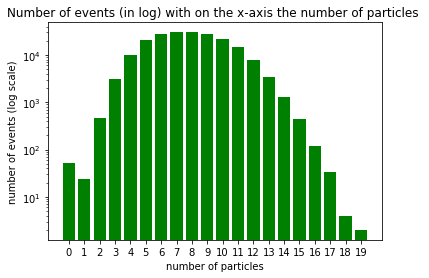

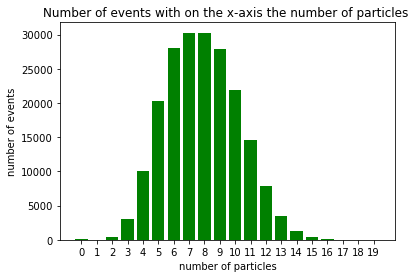

In [7]:
# Input
def Prep_data(file, training = True):
    # Delimiter
    delimiter = ';'

    """
    Since the input file can have a different number of collumns for each row Panda can't read it in directly!
    For this reason we first find the maximum number of collumns.
    """
    max_col = 0
    with open(file, 'r') as temp:
        # Read the lines
        lines = temp.readlines()

        for l in lines:
            # Count number of collumns +1 just to be sure that you have enough cols
            count = len(l.split(delimiter)) + 1

            # Check highest col count
            if count > max_col:
                max_col = count

    # Close file
    temp.close()

    # Get header for easy acces
    colnames_basic = ["event_ID", "process_ID", "event_weight", "MET", "METphi"]
    # Index at which particles start
    index_particles = len(colnames_basic)
    colnames = []
    for i in range(index_particles+1,max_col):
        n = i-index_particles
        # add extra leading 0 to the name to make sorting easier and thus easier to read
        if n <= 9:
            n = "0"+str(n)
        else:
            n = str(n)
        colnames.append("particle_"+n)
    maximum_particles = i-index_particles
    df = pd.read_csv(file, header=None, delimiter=delimiter, names=colnames_basic+colnames)
    df = df.dropna(axis=1, how='all')
    # remove the extra cols from colnames (just to be sure that it fits the data)
    colnames = list(set(df.columns).intersection(set(colnames)))
    colnames.sort()
    
    if training:
        # Check data
        remove_rows = []
        ## Check if event information is complete 
        check_df = df[df.iloc[:,0:index_particles].isna().any(axis=1)]
        print("Checking event information:...")
        if check_df.empty:
            print('event information contains no Na')
        else:
            print("Please check the event information of the following events:")
            print(check_df)
            if rm_Incomplete:
                remove_rows.extend(check_df.index.to_numpy())
                print("Event will be removed")
            else:
                print("Event not removed")
        print("\n")

        # Check if all events contain a particle
        check_df = df[df.iloc[:,[0,index_particles]].isna().any(axis=1)]
        print("Checking particle information:...")
        if check_df.empty:
            print('All events contain atleast 1 particle')
        else:
            print("The following events don't contain any particles:")
            print(check_df)
            if rm_Zero_part:
                remove_rows.extend(check_df.index.to_numpy())
                print("Event will be removed")
            else:
                print("Event not removed and each process_id is given atleast 10 without a particle...")
        
        # if we don't remove the event without particles we will balance it out and oversample each event 10 times with 0 particles
        if not rm_Zero_part:
            Zero_particle_Events = 10
            count_Zero_parts = {}
            pID = np.unique(df["process_ID"])
            for ID in pID:
                if not check_df.empty:
                    existingRows = check_df[check_df.process_ID == ID].shape[0]
                else:
                    existingRows = 0
                if existingRows < Zero_particle_Events:
                    addNrows = Zero_particle_Events - existingRows
                    check_df = pd.concat([check_df,df[df.process_ID == ID].sample(n=addNrows, random_state=1)])
            check_df.loc[:,index_particles:] = np.NaN
            df = pd.concat([df,check_df])
            df.reset_index()
            
        # remove incomplete events (optional)
        if len(remove_rows) != 0:
            df = df.drop(df.index[remove_rows])
        df = df.reset_index()
    
    # count number of particles in each evemt
    number_of_particles = {}
    done = []
    df_checked = df.copy()
    for i,particle in enumerate(range(index_particles+1,len(df.columns))):
        key  = i+1
        value = df_checked[df_checked.iloc[:,[0,particle]].isna().any(axis=1)].index
        number_of_particles[key] = list(value)
        df_checked = df_checked.drop(value)
    # last collumn to check the ones with the most particles
    value = df_checked.index
    number_of_particles[key+1] = list(value)
    Both = True
    LOG_Y = False
    key_to_value_lengths = {k:len(v) for k, v in number_of_particles.items()}
    
    # Plot particle frequency
    if training:
        if Both or LOG_Y:
            plt.bar(key_to_value_lengths.keys(),key_to_value_lengths.values(), color='g',tick_label = list(key_to_value_lengths.keys()), log = True)
            plt.ylabel("number of events (log scale)")
            plt.title("Number of events (in log) with on the x-axis the number of particles ")
            plt.xlabel("number of particles")
            plt.xticks(ticks=list(range(1,21)), labels=list(range(0,20)))
            plt.show()

        if Both or LOG_Y == False:
            plt.bar(key_to_value_lengths.keys(),key_to_value_lengths.values(), color='g',tick_label = list(key_to_value_lengths.keys()))
            plt.ylabel("number of events")
            plt.title("Number of events with on the x-axis the number of particles ")
            plt.xlabel("number of particles")
            plt.xticks(ticks=list(range(1,21)), labels=list(range(0,20)))
            plt.show()
            
    # add collumn with number of particles in event (optional)
    if n_particles:
        n_part = [0] * len(df) 
        for key, value in number_of_particles.items():
            for row_number in value:
                n_part[row_number] = key
        df["n_part"] = n_part
        colnames_basic = colnames_basic+["n_part"]
        df = df[colnames_basic+colnames]
        index_particles = index_particles + 1 # particles move 1 col
    # fill all missing values with "Na,0,0,0,0"
    df = df.fillna("Na,0,0,0,0")
    # Splits each particle collumn into obj, E, pt, eta, phi

    info = ["_obj", "_E", "_pt", "_eta", "_phi"]
    PF = len(info)
    df_split = df.copy()
    # new data frame with split value columns 
    for index, part in enumerate(colnames):
        new = df.iloc[:,index+index_particles].str.split(",", n = PF, expand = True)            
        for i, inf in enumerate(info):
            colname = part+inf
            if i == 0:
                df_split[colname] = new[i]
            else:
                df_split[colname] = new[i].astype(float)
        df_split.drop(columns =[part], inplace = True) 
    df = df_split
    obj_cols =  [s + info[0] for s in colnames] # get all column names of each obj for each particle
    if training:
        enc = LabelBinarizer()
        enc.fit(np.unique(df["process_ID"]))
        IDS, counts = np.unique(df["process_ID"],return_counts=True)
        counts = [x / sum(counts) for x in counts]
        priors = dict(zip(IDS,counts))
        OH_Y = enc.transform(df["process_ID"])
        df.insert(2, "process_ID_OH",OH_Y.tolist(), True) 
        index_particles += 1
        # Shows how the labels changed
        OH_dict = dict(zip(enc.classes_,enc.transform(enc.classes_).tolist()))
        
        # for binary classification
        Binary_Y =[]
        index = OH_dict[signal].index(1)
        for label in OH_Y:
            Binary_Y.append(label[index])
        df.insert(3, "Signal",Binary_Y, True) 
        index_particles += 1
        
    # set particle types to categorical
    objects = np.unique(df[obj_cols])
    particle_labels_df = df[obj_cols]
    OE = {}
    for i,obj in enumerate(objects):
        OE[obj] = i
    for cols in obj_cols:
        df[cols].replace(OE, inplace=True)
        
    # For the LSTM we splits the dataframe into event data and particle data
    event_data = df[["MET","METphi","n_part"]]
    particle_df = df.iloc[:,index_particles::]
    
    # Instead of a categorical particle type, we can create a dummy variable (optional)
    if dummy:
        dummies = pd.get_dummies(particle_labels_df,obj_cols,drop_first=True)
        particle_types= []
        part_keys = list(OE.keys())[1:] #remove first index which is na
        for col in obj_cols:
            particle_types.extend([col + "_" + s for s in part_keys])
        for pt in particle_types:
            if pt not in dummies:
                dummies[pt] = np.zeros(shape=(df.shape[0]), dtype=int)
        dummies = dummies.reindex(sorted(dummies.columns), axis=1)
        n_part_types = len(part_keys)
        particle_df.drop(obj_cols,axis=1,inplace=True)
        particle_df = pd.concat([dummies,particle_df], axis=1)
        particle_df = particle_df.reindex(sorted(particle_df.columns), axis=1)
        PF += (n_part_types-1) #-1 since one col existed
    # Reshape the data to become [sample,particles,features] making it more flexible
    particle_data = particle_df.values.reshape(particle_df.shape[0],int(particle_df.shape[1]/PF),PF)
    if training:
        return colnames_basic,index_particles,maximum_particles,df,colnames,OH_Y,event_data,particle_data,PF,priors, enc
    else:
        return colnames_basic,index_particles,maximum_particles,df,colnames, event_data,particle_data,PF
colnames_basic,index_particles,maximum_particles,df,colnames,OH_Y,event_data,particle_data,PF, priors, enc= Prep_data("data.csv")

In [8]:
priors

{'4top': 0.4999250187453137,
 'ttbar': 0.12501874531367158,
 'ttbarHiggs': 0.12501874531367158,
 'ttbarW': 0.12501874531367158,
 'ttbarZ': 0.12501874531367158}

In [9]:
df

,event_ID,process_ID,process_ID_OH,Signal,event_weight,MET,METphi,n_part,particle_01_obj,particle_01_E,...,particle_18_obj,particle_18_E,particle_18_pt,particle_18_eta,particle_18_phi,particle_19_obj,particle_19_E,particle_19_pt,particle_19_eta,particle_19_phi
0,21,ttbarW,"[0, 0, 0, 1, 0]",0,7.005800e-06,56339.8,-1.526640,8,5,188739.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,21,ttbarW,"[0, 0, 0, 1, 0]",0,7.005800e-06,23717.1,2.662630,7,5,129988.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,30,4top,"[1, 0, 0, 0, 0]",1,1.930000e-07,112393.0,-1.130090,14,1,225026.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,57,ttbarHiggs,"[0, 0, 1, 0, 0]",0,2.068090e-05,26003.0,1.635830,8,5,241312.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,21,ttbarW,"[0, 0, 0, 1, 0]",0,7.005800e-06,20312.2,-1.355550,8,1,401808.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200045,21,ttbarZ,"[0, 0, 0, 0, 1]",0,1.174310e-05,19507.0,3.082580,1,0,0.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
200046,21,ttbarZ,"[0, 0, 0, 0, 1]",0,1.174310e-05,21929.7,-0.370587,1,0,0.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
200047,21,ttbarZ,"[0, 0, 0, 0, 1]",0,1.174310e-05,60728.4,2.614460,1,0,0.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
200048,21,ttbarZ,"[0, 0, 0, 0, 1]",0,1.174310e-05,23586.7,-2.806820,1,0,0.0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [10]:
LABELS = list(enc.classes_)
LABELS

['4top', 'ttbar', 'ttbarHiggs', 'ttbarW', 'ttbarZ']

# Keras 

## Split X

In [11]:
Columns_to_remove = ["process_ID", "event_ID", "event_weight", "process_ID_OH", "Signal"]
X_cols = list(df.columns)
for remove in Columns_to_remove:
    X_cols.remove(remove)
n_features = len(X_cols)
X = df[X_cols].values

## Training parameter setup

In [12]:
ep = 20
bs= 256
splits = 10
kf = KFold(n_splits=splits,shuffle=True, random_state=1)
opt = "Adam"

# a) a simple discriminator neural network

The simpelest model there is:
1 hidden layer without any other methods applied like dropout or batch normalization.

In [13]:
y = df["Signal"].values

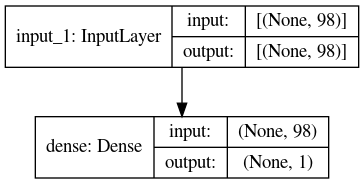

In [14]:
def Simple_layers(Input):
    Output= Dense(1, activation='sigmoid')(Input)
    return Output

def Simple_discriminator(input_dim):
    Input = keras.Input(input_dim)
    Output = Simple_layers(Input)
    model = keras.Model(inputs=[Input],outputs=[Output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model_simple_binary = Simple_discriminator(X.shape[1])
keras.utils.plot_model(model_simple_binary, "Simple_discriminator.png", show_shapes=True)

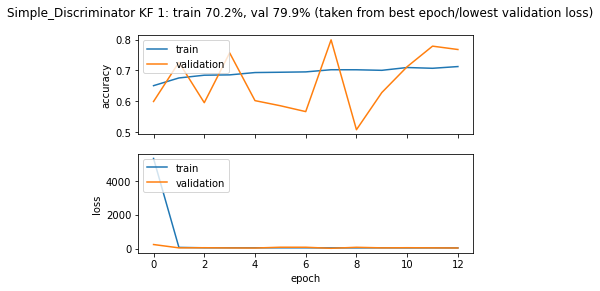

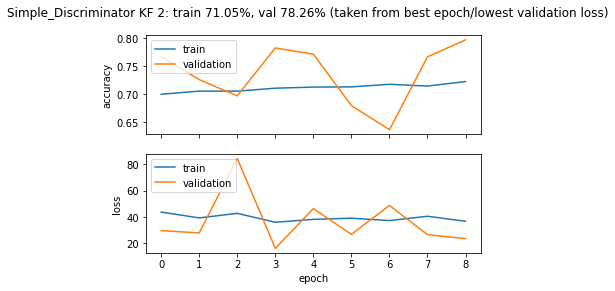

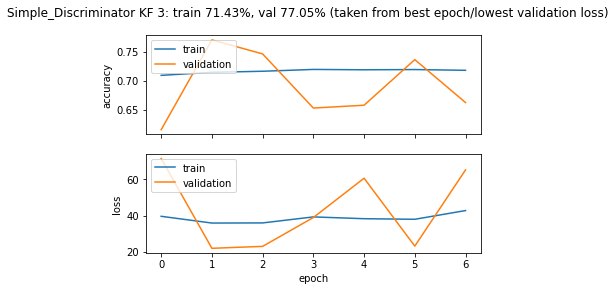

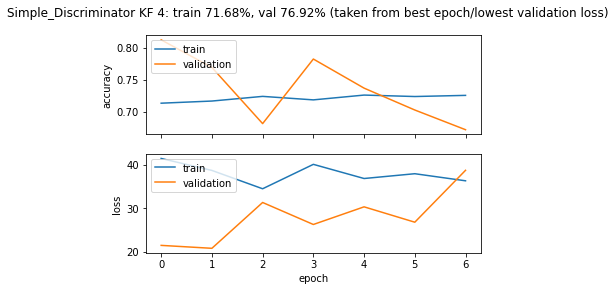

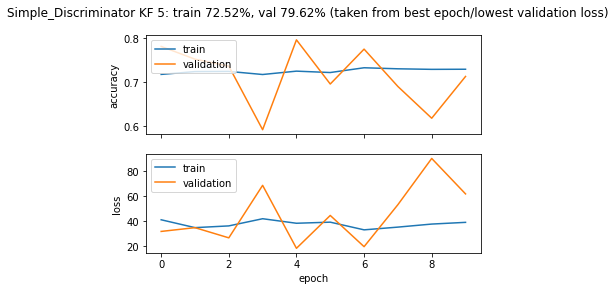

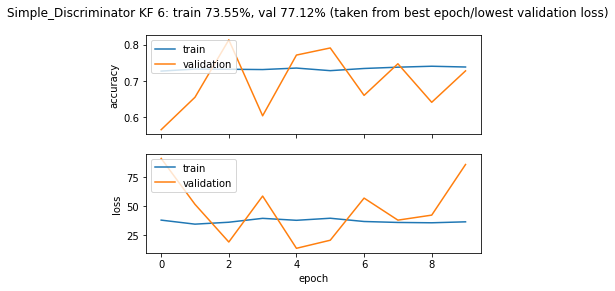

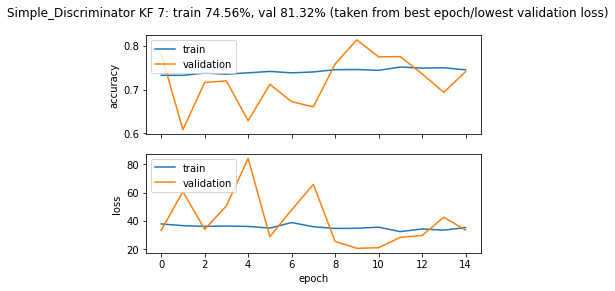

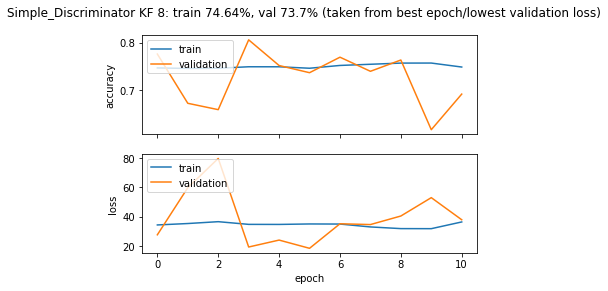

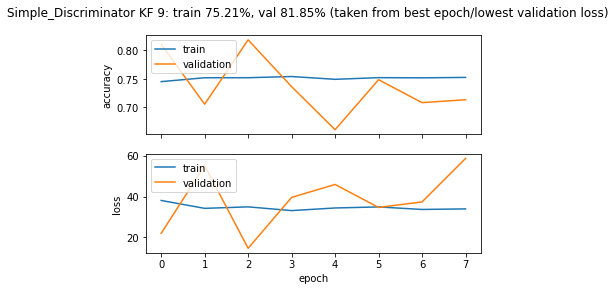

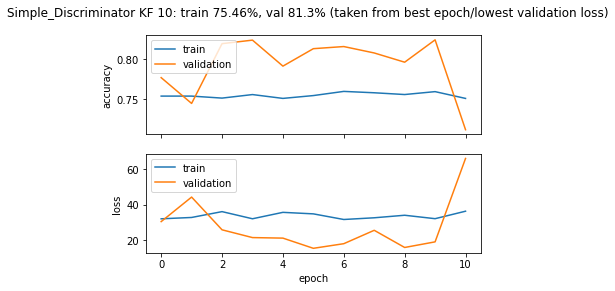

Simple_Discriminator model; train=73.03%, validation=78.7%


In [15]:
cross_validation(model_simple_binary, kf,X,y, "Simple_Discriminator")

# b) a multiclass discriminator neural network

A multiclass discrminator with multiple hidden layers contains dropout and batch normalization.
Without the dropout showed significant chance of overfitting

In [16]:
# Get y values for multi-class classification
y_M = keras.utils.to_categorical(OH_Y)[:,:,1]
NClasses = y_M.shape[1]

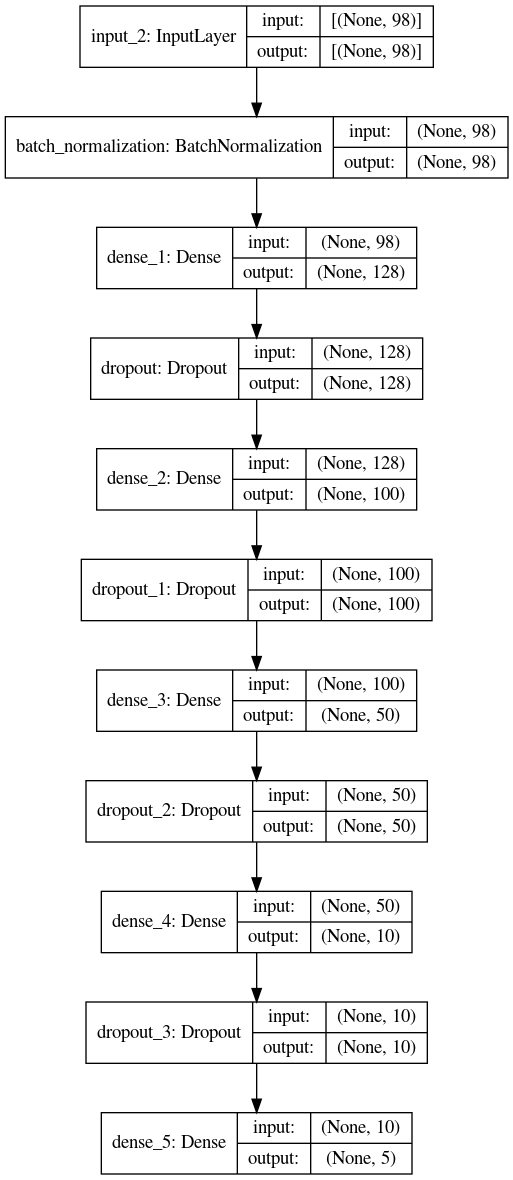

In [17]:
def Multi_layers(Input,nclasses,do = 0.2):
    batch = layers.BatchNormalization()(Input)
    Multi = Dense(128, activation='relu')(batch)
    Multi = Dropout(do)(Multi)
    Multi = Dense(100, activation='relu')(Multi)
    Multi = Dropout(do)(Multi)
    Multi = Dense(50, activation='relu')(Multi)
    Multi = Dropout(do)(Multi)
    Multi = Dense(10, activation='relu')(Multi)
    Multi = Dropout(do)(Multi)
    Multi = Dense(nclasses, activation='softmax')(Multi)
    return Multi

def Multi_discriminator(input_dim,nclasses):
    Input = keras.Input(input_dim)
    Output = Multi_layers(Input,nclasses)
    model = keras.Model(inputs=[Input],outputs=[Output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model_mutli = Multi_discriminator(X.shape[1],NClasses)
keras.utils.plot_model(model_mutli, "Multi_discriminator.png", show_shapes=True)

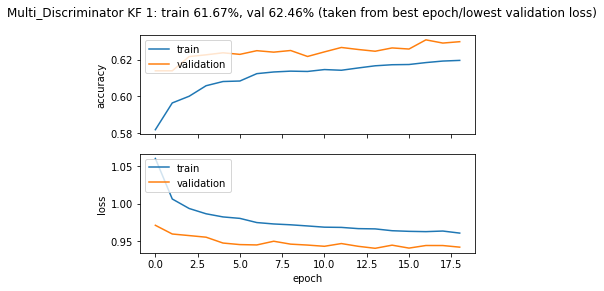

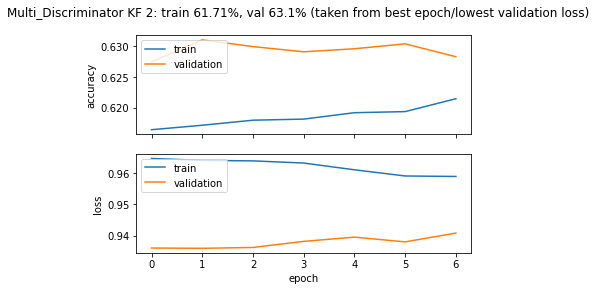

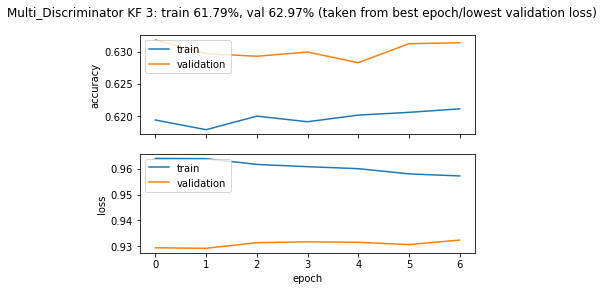

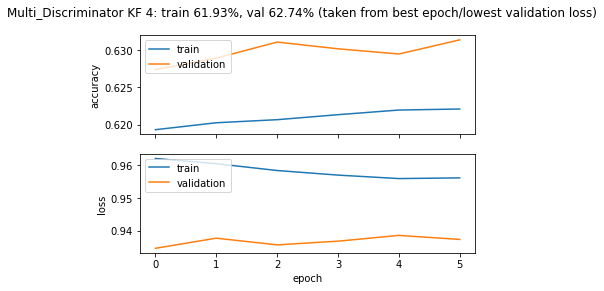

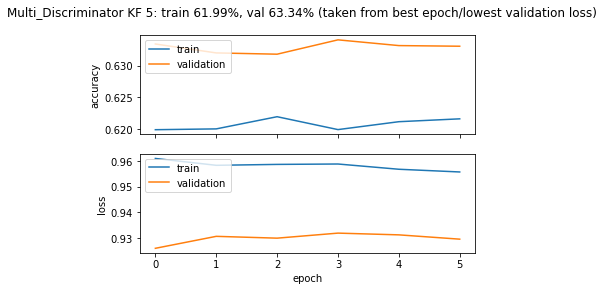

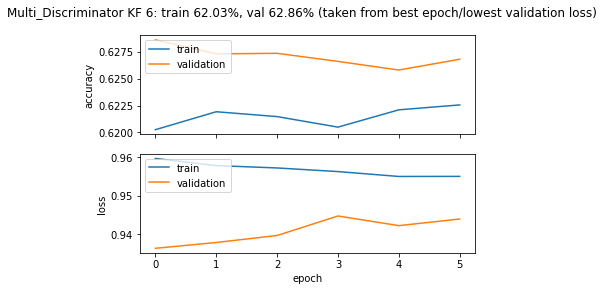

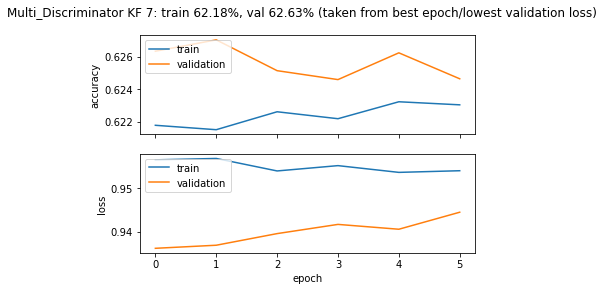

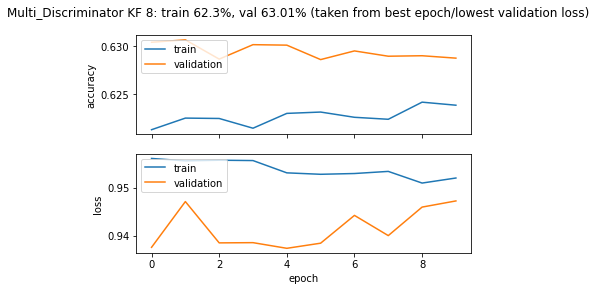

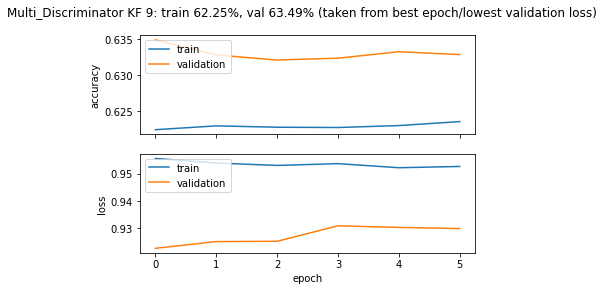

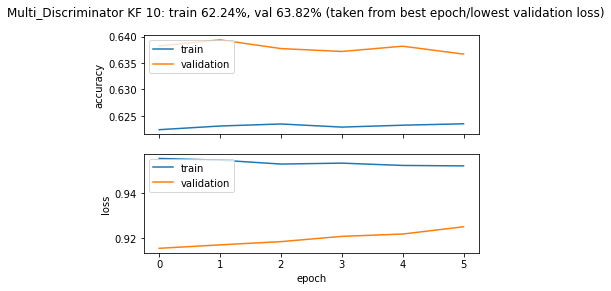

Multi_Discriminator model; train=62.01%, validation=63.04%


In [18]:
cross_validation(model_mutli, kf,X,y_M, "Multi_Discriminator")

# c)  use the different class probabilities

Merge the models of A) and B). This is a significant improvement!

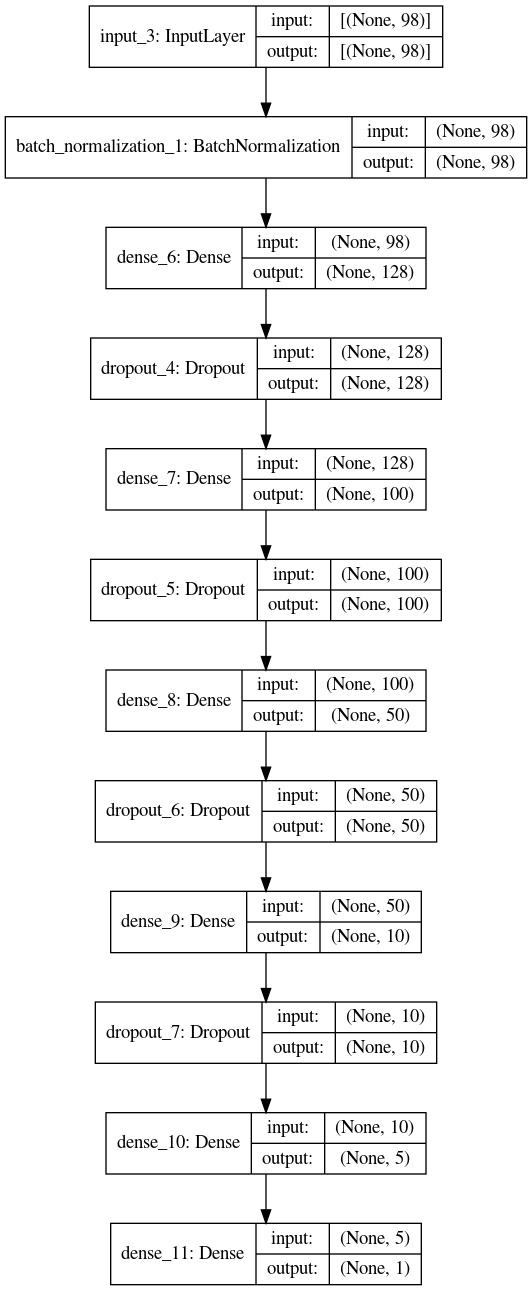

In [19]:
def Multi_discriminator_binary_out(input_dim,nclasses):
    Input = keras.Input(input_dim)
    Multi = Multi_layers(Input,nclasses)
    Output = Simple_layers(Multi)
    model = keras.Model(inputs=[Input],outputs=[Output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model_multi_binary = Multi_discriminator_binary_out(X.shape[1],NClasses)
keras.utils.plot_model(model_multi_binary, "Multi_discriminator_binary.png", show_shapes=True)

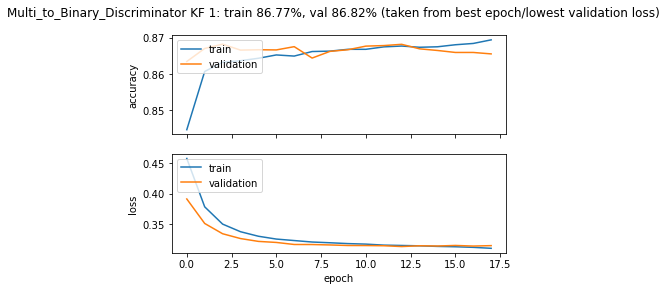

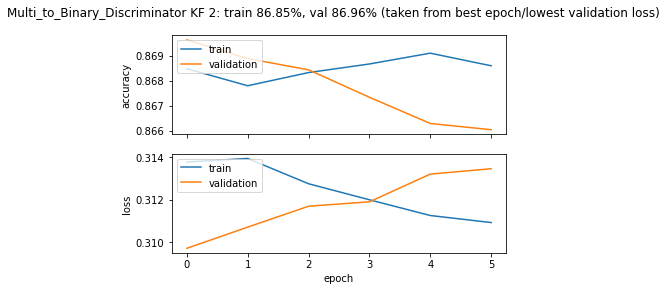

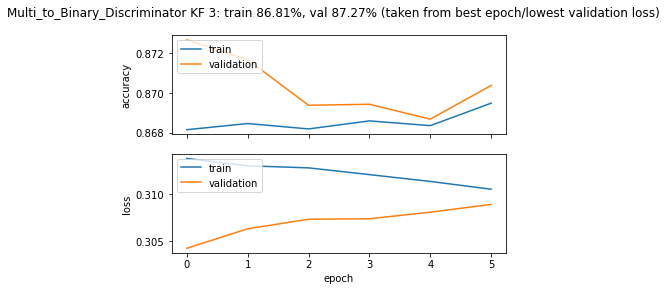

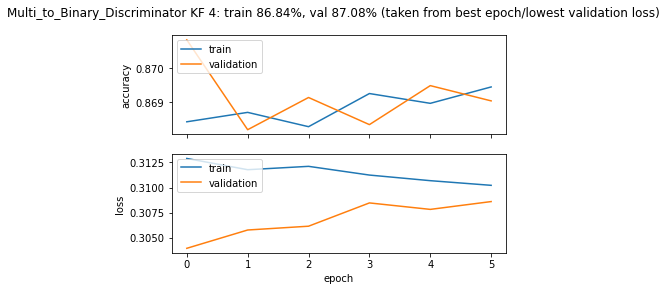

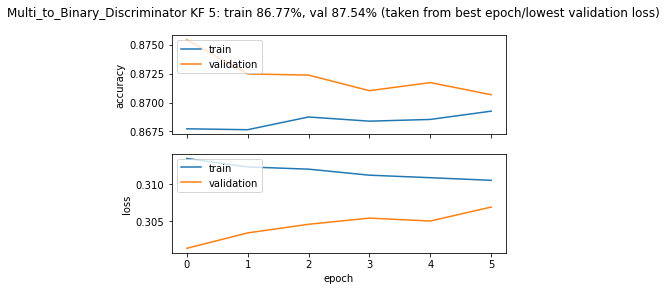

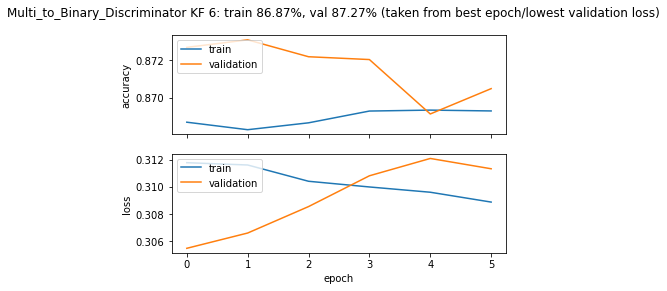

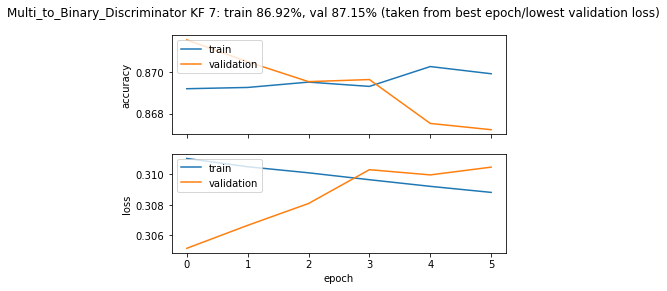

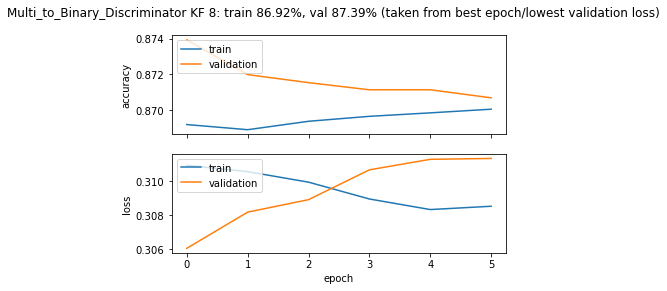

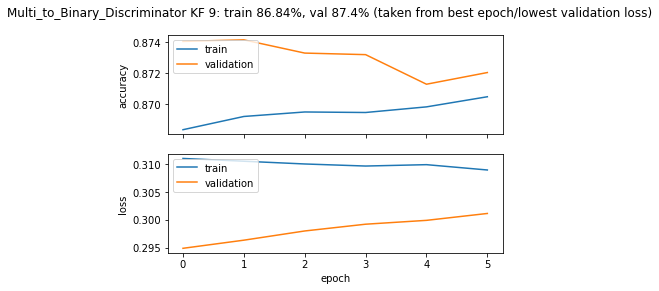

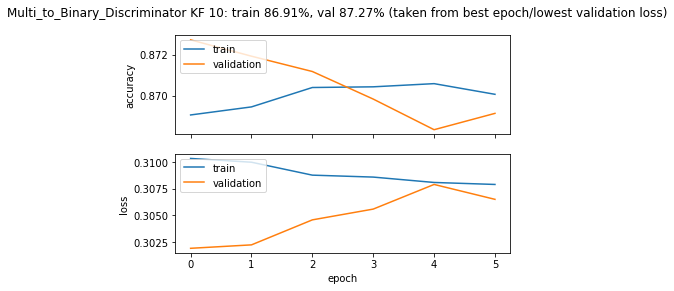

Multi_to_Binary_Discriminator model; train=86.85%, validation=87.22%


In [20]:
cross_validation(model_multi_binary, kf,X,y, "Multi_to_Binary_Discriminator")

# d) My creation

## LSTM model

In [21]:
def LSTM_layers(Particle_input,Event_input,PF ,do):
    # Input the particle specific data
    BN_P = layers.BatchNormalization()(Particle_input)
    Particle_features = layers.Bidirectional(layers.LSTM(100, input_shape=(1,PF), activation="relu",dropout=do,recurrent_dropout=do, return_sequences=False), merge_mode="ave")(BN_P)
    # Input event specific data
    Event_features = layers.BatchNormalization()(Event_input)
    

    # Merge all available features into a single large vector via concatenation
    x = layers.concatenate(axis=1, inputs=[Event_features, Particle_features])
    return x

def Create_LSTM(EInput,PF,Binary= True, LSTM = False,do = 0.2):
    # Particle input in the format of [samples,particles,particle features (PF)]
    Particle_input = keras.Input(shape=(None,PF), name="Particles") 
    # Event input in the format of [samples,event features]
    Event_input = keras.Input(shape=(EInput), name="Event")
    
    # Add all layers
    dense = LSTM_layers(Particle_input,Event_input,PF ,do)
    
    # Get multiclass output
    Output = Multi_layers(dense,NClasses)
    
    # If result should be binary convert the multiclass output to binary
    if Binary:
        Output = Simple_layers(Output)
    
    # Stick a logistic regression for priority prediction on top of the features
    output = layers.Dense(1, name="event_class", activation='sigmoid')(dense)
    # Instantiate an end-to-end model predicting classes
    LSTM = keras.Model(
        inputs=[Particle_input, Event_input],
        outputs=[Output])
    
    # Loss used depends on expected output
    if Binary:
        LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return LSTM

### LSTM output binary

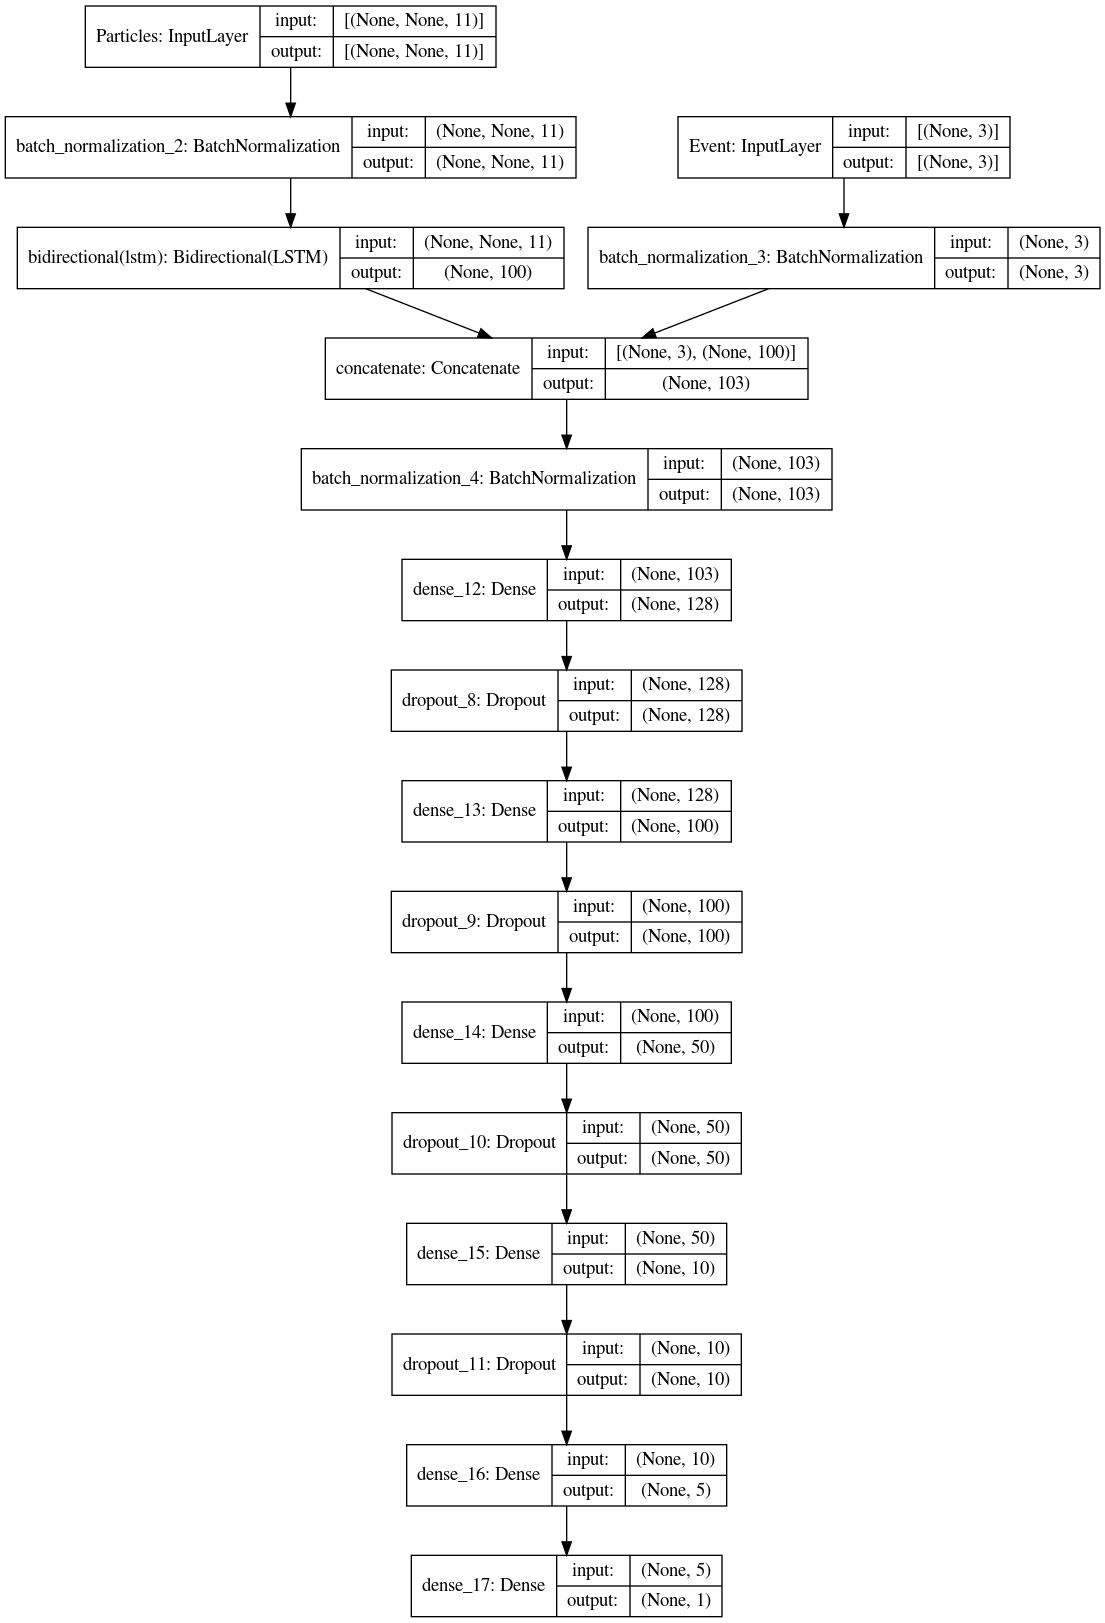

In [22]:
LSTM = Create_LSTM(EInput=event_data.shape[1],PF=PF)
keras.utils.plot_model(LSTM, "multi_input_Binary_LSTM_model.png", show_shapes=True)

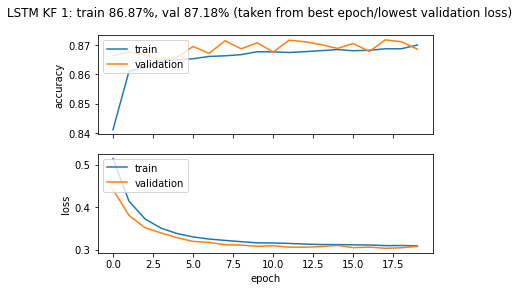

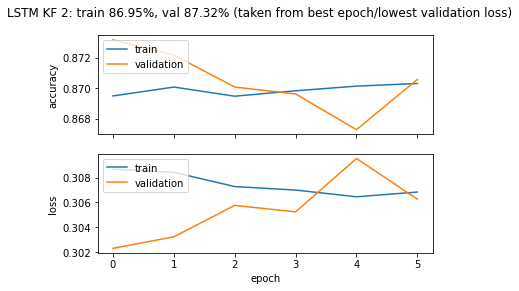

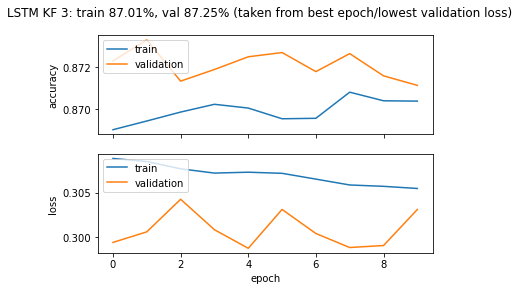

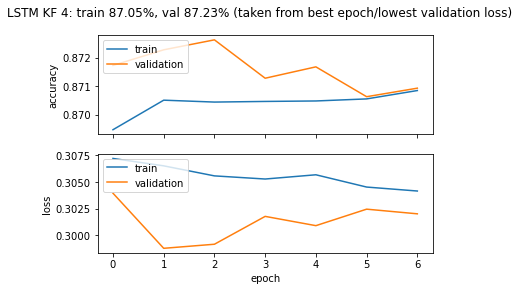

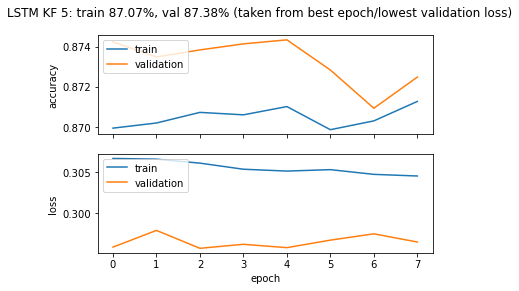

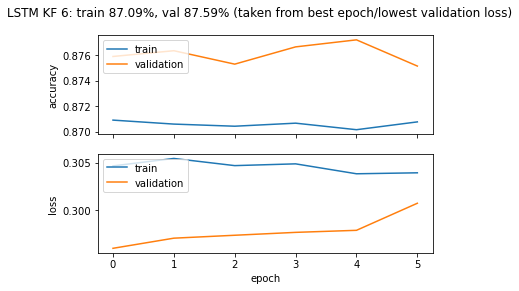

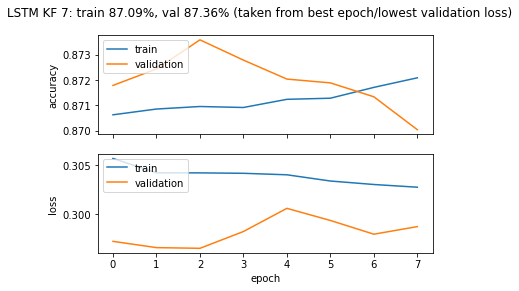

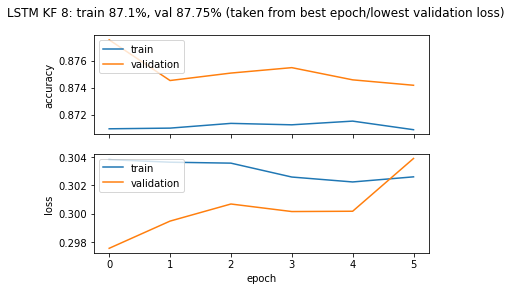

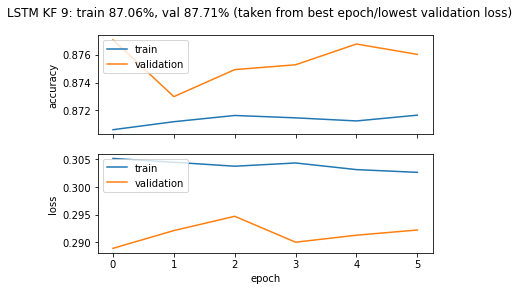

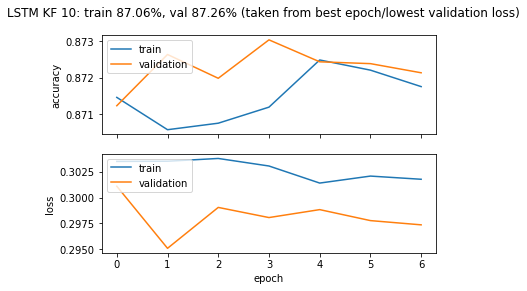

LSTM model; train=87.04%, validation=87.4%


In [23]:
cross_validation(LSTM, kf,{"particle_data": particle_data, "event_data":event_data},y, "LSTM")

### LSTM output multiclass

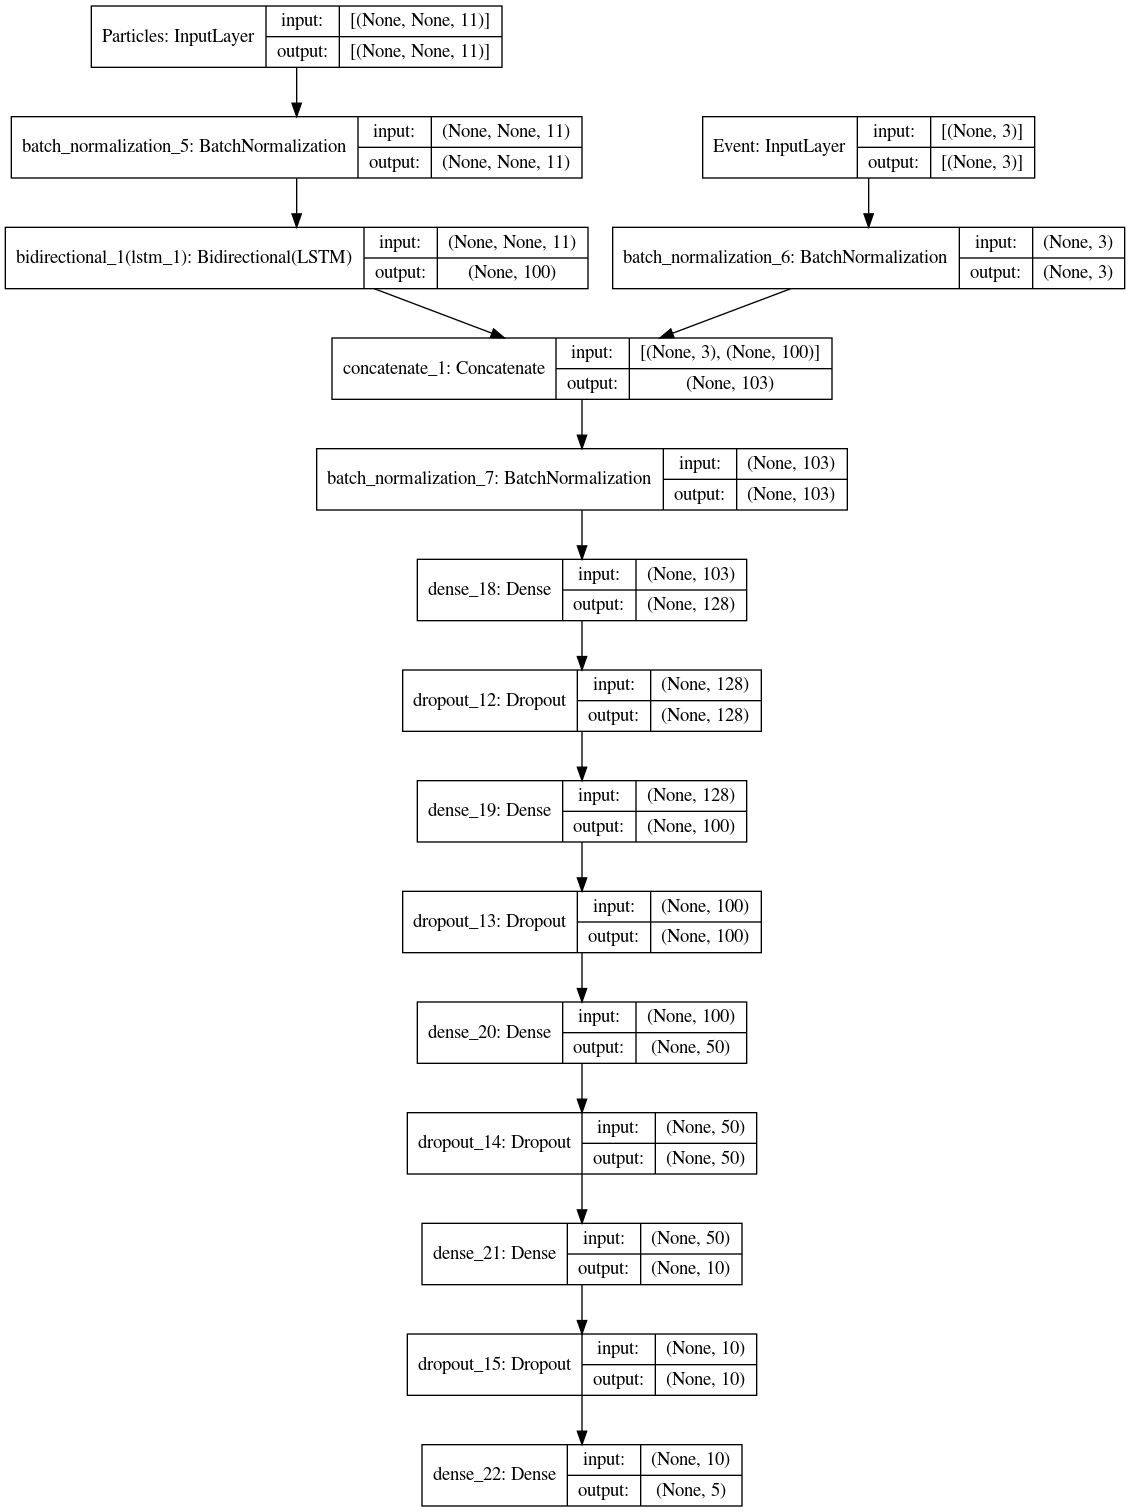

In [24]:
LSTM_M = Create_LSTM(EInput=event_data.shape[1],PF=PF,Binary=False)
keras.utils.plot_model(LSTM_M, "multi_input_Multi_LSTM_model.png", show_shapes=True)

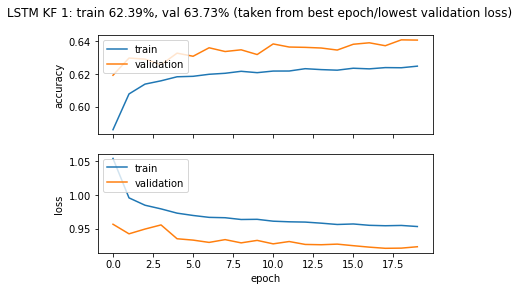

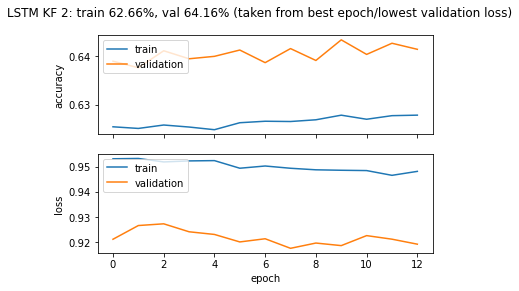

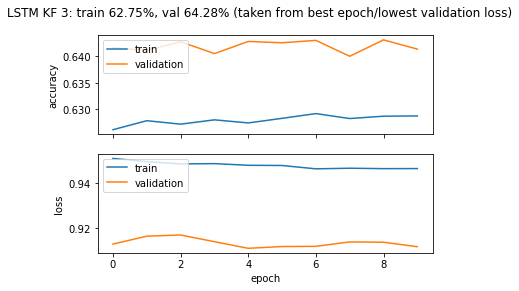

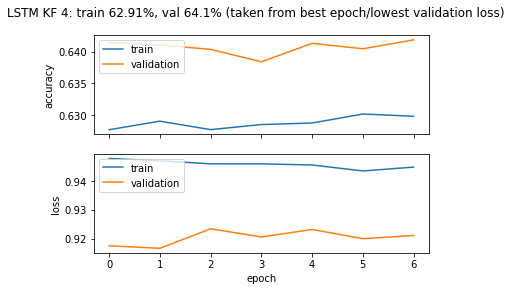

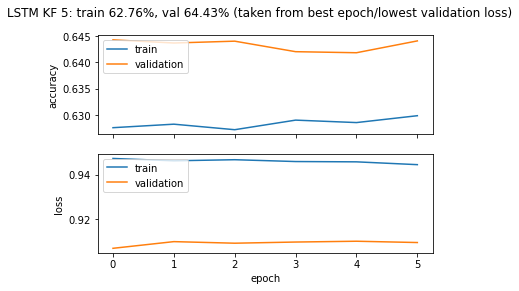

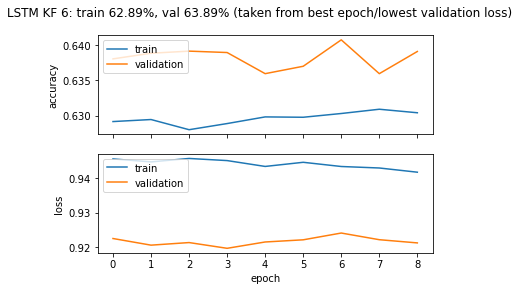

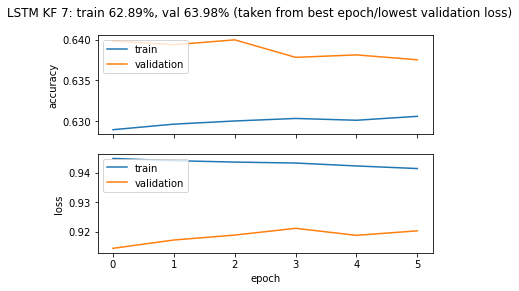

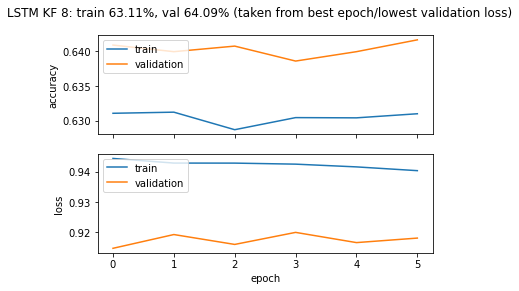

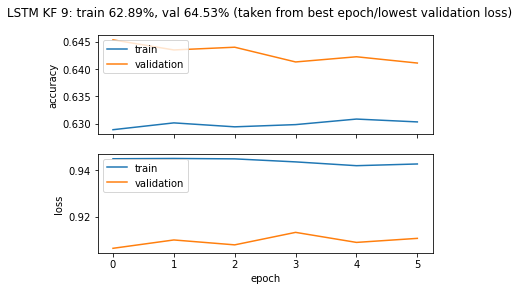

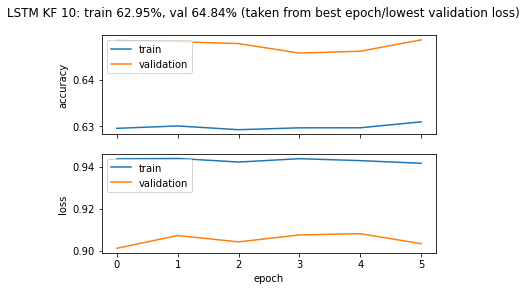

LSTM model; train=62.82%, validation=64.2%


In [25]:
cross_validation(LSTM_M, kf,{"particle_data": particle_data, "event_data":event_data},y_M, "LSTM")

# Train model without cross-validation (full_dataset)


In [26]:
# Fit a model and save checkpoints to get the best one.
def fit_model_for_testing(model,X,y, model_name, extra_name,eps,bss,ts, prior,max_time_sec = int(60*60),cut_off=50,timestop = True,earlystop=True):
    # Create train and val set
    X_train,y_train,X_val,y_val = split_dataset(X,y,ts,model_name,prior)
    callbacks = []
    if timestop:
        time_stopping_callback = tfa.callbacks.TimeStopping(seconds=max_time_sec, verbose=0)
        callbacks.append(time_stopping_callback)
        
    if earlystop:
        ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=cut_off, min_delta=0, restore_best_weights=True)
        callbacks.append(ES)
        
    MCP = keras.callbacks.ModelCheckpoint('{}{}.hdf5'.format(model_name,extra_name), save_best_only=True, monitor='val_loss')
    callbacks.append(MCP)
    
    history, model = fit_model(model,X_train, y_train, (X_val,y_val), callbacks,eps,bss)
    # Retrieve values for the best epoch since we also store the weights of the best model
    loss_list = history.history["val_loss"]
    best_model_idx =  loss_list.index(min(loss_list))
    train_acc = history.history["accuracy"][best_model_idx]
    val_acc = history.history["val_accuracy"][best_model_idx]

    train_acc = to_percentage(train_acc)
    val_acc = to_percentage(val_acc)
    plot_history(history.history, True, "{} : train {} val {} (taken from best epoch/lowest validation loss)".format(model_name,train_acc ,val_acc))
   
    #posterior ∝  likelihood x prior
    print("Apply bayesian prediction:")
    y_pred= bayesian_prediction(model,X_val,prior,model_name,extra_name)
    print("Score on validation set when using priors: {}%".format(to_percentage(accuracy_score(y_val, y_pred))))
    if np.array(y_pred).ndim == 1:
        labels = [1,0]
        array = confusion_matrix(y_val,y_pred, labels=labels)
    else:
        labels=list(enc.classes_)
        array = confusion_matrix(enc.inverse_transform(y_val),enc.inverse_transform(np.array(y_pred)), labels=labels)
    df_cm = pd.DataFrame(array, index = [i for i in labels],
                  columns = [i for i in labels])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='g')

def split_dataset(X,y,ts,model_name,priors):
    split= False
    # LSTM needs different type of input
    if model_name.upper() == "LSTM":
        particle_data = X["particle_data"]
        event_data = X["event_data"]
        X = particle_data
        split = True
    indices = np.arange(X.shape[0])
    # usual train-val split
    train_idx, val_idx = train_test_split(indices, test_size=ts, random_state=1)
    y_train, y_test = y[train_idx], y[val_idx]
    if split:
        Train_x_part, Test_x_part = particle_data[train_idx,:,:], particle_data[val_idx,:,:]
        Train_x_event, Test_x_event = event_data.iloc[train_idx,:], event_data.iloc[val_idx,:]
        X_train = {"Particles": Train_x_part, "Event":Train_x_event}
        X_test = [Test_x_part,Test_x_event]

    else:
        X_train, X_test = X[train_idx], X[val_idx]
    return X_train,y_train,X_test,y_test

# function to get prediction when using priors
def bayesian_prediction(model,X_val,prior,model_name,extra_name,Classes = True):
    # load the best model checkpoint
    model.load_weights('{}{}.hdf5'.format(model_name,extra_name))
    likelihood = model.predict(X_val)
    y_pred = []
    signal_prior = prior[signal]
    # Check if output is binary
    if likelihood.shape[1] == 1:
        background_prior = 1 - signal_prior
        for s in likelihood:
            background = 1 - s
            sig = s * signal_prior
            back = background * background_prior
            if Classes:
                # Returns classes instead of probabilities, 0 if s*prior probability is smaller or equal to background*prior
                if sig <= back:
                    y_pred.append(0)
                else:
                    y_pred.append(1)
            else:
                # Get the probability after applying the priors and divide this with the total of both the probabilities
                prob = sig/(sig+back)
                y_pred.append(prob[0])
    else:
        # Using priors for multi-class prediction
        for s in likelihood:
            pred_list = [0,0,0,0,0]
            pred_values = [a*b for a,b in zip(list(prior.values()),s)]
            pred_values = [x / sum(pred_values) for x in pred_values]
            if Classes:
                idx = pred_values.index(max(pred_values))
                pred_list[idx] = 1
                y_pred.append(pred_list)
            else:
                y_pred.append(pred_values)
    return y_pred  

In [27]:
test_ep = 200
test_bs = 256
Testsize = 0.1

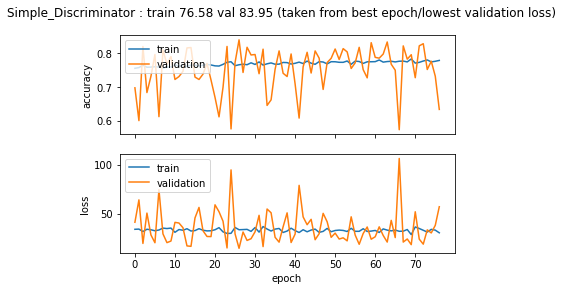

Apply bayesian prediction:
Score on validation set when using priors: 83.95%


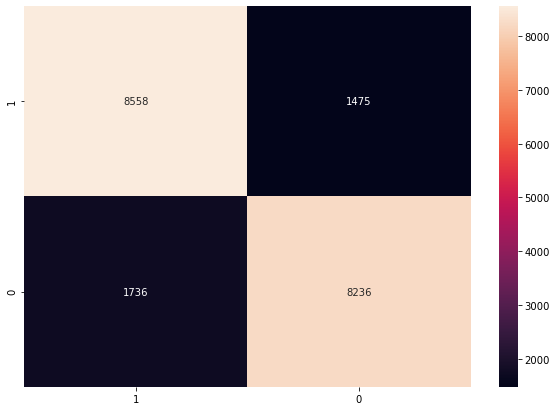

In [28]:
fit_model_for_testing(model=model_simple_binary,X=X,y=y, model_name="Simple_Discriminator",extra_name="_Binary",eps=test_ep,bss=test_bs,ts=Testsize,prior=priors)


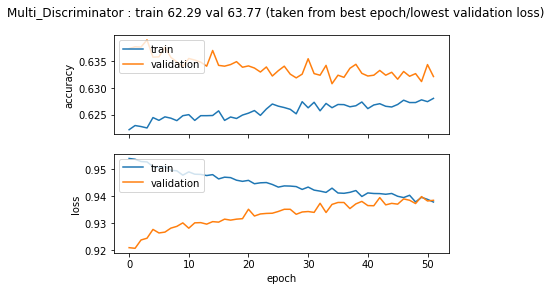

Apply bayesian prediction:
Score on validation set when using priors: 61.67%


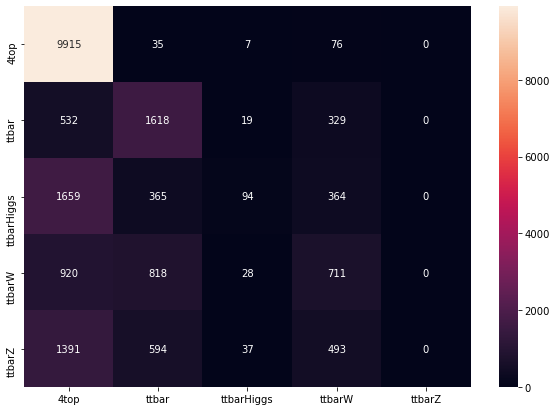

In [29]:
fit_model_for_testing(model=model_mutli,X=X,y=y_M, model_name="Multi_Discriminator",extra_name="_Multi",eps=test_ep,bss=test_bs,ts=Testsize,prior=priors)


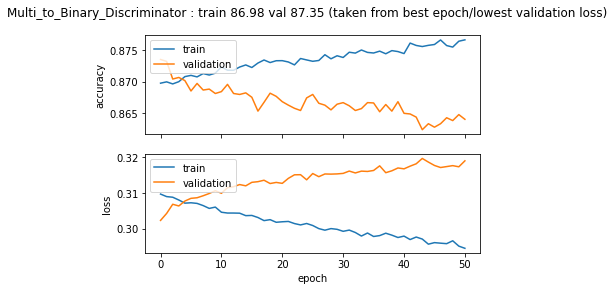

Apply bayesian prediction:
Score on validation set when using priors: 87.35%


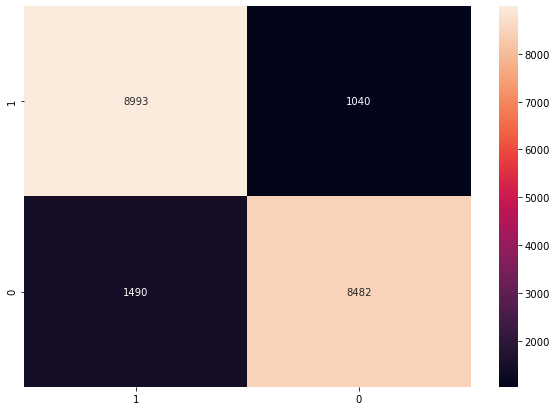

In [30]:
fit_model_for_testing(model=model_multi_binary,X=X,y=y, model_name="Multi_to_Binary_Discriminator",extra_name="_Binary",eps=test_ep,bss=test_bs,ts=Testsize,prior=priors)

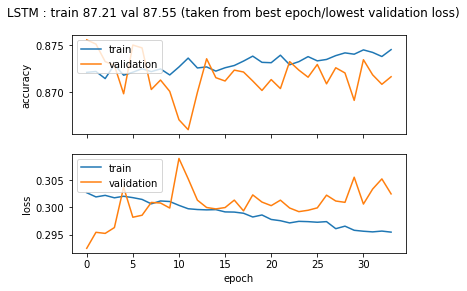

Apply bayesian prediction:
Score on validation set when using priors: 87.56%


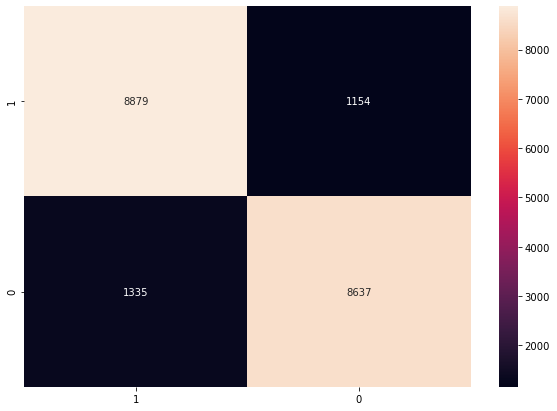

In [31]:
fit_model_for_testing(model=LSTM,X={"particle_data": particle_data, "event_data":event_data},y=y, model_name="LSTM",extra_name="_Binary",eps=test_ep,bss=test_bs,ts=Testsize,prior=priors)

# Test data

In [32]:
test_priors = {"4top": 0.04,"ttbar":0.02,"ttbarHiggs":0.19,"ttbarW":0.51,"ttbarZ":0.24}

In [33]:
if not os.path.exists("testdata.csv"):
    !wget -O testdata.csv "https://cernbox.cern.ch/index.php/s/32dMTvm5GG3QUiy/download"
    Run_done = True

test_colnames_basic,test_index_particles,test_maximum_particles,test_df,test_colnames,test_event_data,test_particle_data,test_PF = Prep_data("testdata.csv",training=False)


--2021-04-27 08:03:53--  https://cernbox.cern.ch/index.php/s/32dMTvm5GG3QUiy/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 188.184.97.72, 128.142.32.26, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13278497 (13M) [text/csv]
Saving to: ‘testdata.csv’

testdata.csv        100%[===================>]  12.66M  6.97MB/s    in 1.8s    

Last-modified header invalid -- time-stamp ignored.
2021-04-27 08:03:57 (6.97 MB/s) - ‘testdata.csv’ saved [13278497/13278497]



## Prepare X for testing

In [34]:
test_Columns_to_remove = ["process_ID", "event_ID", "event_weight"]
test_X_cols = list(test_df.columns)
test_X = np.zeros((test_df.shape[0],X.shape[1]), dtype=int)
for remove in test_Columns_to_remove:
    test_X_cols.remove(remove)
test_n_features = len(test_X_cols)
test_df_values = test_df[test_X_cols].values
test_X[:, :test_df_values.shape[1]] = test_df_values

In [35]:
# Function to make CSV files
def mk_prediction_csv(model,test_X,test_prior,model_name,extra_name,binary):
    # Get bayesian prediction
    y_pred = bayesian_prediction(model,test_X,test_prior,model_name,extra_name,Classes = False)
    if binary:
        # Create 2 cols 1 contains id, other contains probability of signal
        df = pd.DataFrame({"event_number":test_df["event_ID"],signal:y_pred})
    else:
        y_pred = np.array(y_pred)
        ids = np.array(test_df["event_ID"])
        
        ids = ids.reshape(test_df["event_ID"].shape[0],1)
        data = np.append(ids,y_pred, 1)
        # Create 6 cols 1 contains id, 1 contains probability of signal, and than the 4 backgrounds
        LABS = ["event_number"]
        LABS.extend(LABELS)
        df = pd.DataFrame(data, columns=LABS)
        convert_dict = {'event_number': int}
        df = df.astype(convert_dict)
    print(df)
    df.to_csv('{}{}.csv'.format(model_name,extra_name),index=False)


## Create prediction with model A

In [36]:
mk_prediction_csv(model=model_simple_binary,test_X=test_X,test_prior=test_priors,model_name="Simple_Discriminator",extra_name="_Binary", binary=True)

       event_number          4top
0                 0  1.000000e+00
1                 1  0.000000e+00
2                 2  0.000000e+00
3                 3  1.462051e-06
4                 4  0.000000e+00
...             ...           ...
49995         49995  5.186816e-03
49996         49996  9.414617e-25
49997         49997  0.000000e+00
49998         49998  0.000000e+00
49999         49999  1.000000e+00

[50000 rows x 2 columns]


## Create prediction with model B

In [37]:
mk_prediction_csv(model=model_mutli,test_X=test_X,test_prior=test_priors,model_name="Multi_Discriminator",extra_name="_Multi", binary=False)

       event_number      4top     ttbar  ttbarHiggs    ttbarW    ttbarZ
0                 0  0.132339  0.010116    0.228112  0.368583  0.260850
1                 1  0.000013  0.062458    0.092927  0.673353  0.171249
2                 2  0.000145  0.043072    0.108819  0.656089  0.191875
3                 3  0.019619  0.011815    0.143913  0.588639  0.236014
4                 4  0.015929  0.020644    0.141342  0.581323  0.240762
...             ...       ...       ...         ...       ...       ...
49995         49995  0.064526  0.006888    0.200590  0.482159  0.245837
49996         49996  0.000489  0.022044    0.110582  0.677186  0.189699
49997         49997  0.001062  0.035038    0.121934  0.626672  0.215295
49998         49998  0.000376  0.033603    0.116361  0.654394  0.195265
49999         49999  0.358087  0.005638    0.211178  0.189631  0.235467

[50000 rows x 6 columns]


## Create prediction with model C

In [38]:
mk_prediction_csv(model=model_multi_binary,test_X=test_X,test_prior=test_priors,model_name="Multi_to_Binary_Discriminator",extra_name="_Binary", binary=True)

       event_number      4top
0                 0  0.049942
1                 1  0.000357
2                 2  0.000373
3                 3  0.004649
4                 4  0.003542
...             ...       ...
49995         49995  0.032246
49996         49996  0.000376
49997         49997  0.001114
49998         49998  0.000383
49999         49999  0.113236

[50000 rows x 2 columns]


## Create prediction with model D

In [39]:
mk_prediction_csv(model=LSTM,test_X={"Particles": test_particle_data, "Event":test_event_data},test_prior=test_priors,model_name="LSTM",extra_name="_Binary", binary=True)

       event_number      4top
0                 0  0.043382
1                 1  0.000241
2                 2  0.000246
3                 3  0.017381
4                 4  0.003302
...             ...       ...
49995         49995  0.012353
49996         49996  0.000278
49997         49997  0.001866
49998         49998  0.000278
49999         49999  0.147024

[50000 rows x 2 columns]
